In [54]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart
import matplotlib.pyplot as plt
import asyncio
import datetime
import random
import websockets
import nest_asyncio
import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import run_websocket_server, run_http_server
import tensorflow as tf
import math
sys.path.insert(0, os.path.abspath('..'))
# Import DeepExplain
from deepexplain.tf.v1_x import DeepExplain

nest_asyncio.apply()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# params 432, 368
w, h = 432, 368
image_path = './data/images/muscle.jpg'
image_path_black = './data/images/muscle_black1.jpg'
model = 'cmu'
resize_out_ratio = 2.0
image = common.read_imgfile(image_path, w, h)
image_black = common.read_imgfile(image_path_black, w, h)
def put_heatmap(heatmap, plane_idx, center, sigma):
        center_x, center_y = center
        _, height, width = heatmap.shape[:3]

        th = 4.6052
        delta = math.sqrt(th * 2)

        x0 = int(max(0, center_x - delta * sigma))
        y0 = int(max(0, center_y - delta * sigma))

        x1 = int(min(width, center_x + delta * sigma))
        y1 = int(min(height, center_y + delta * sigma))

        for y in range(y0, y1):
            for x in range(x0, x1):
                d = (x - center_x) ** 2 + (y - center_y) ** 2
                exp = d / 2.0 / sigma / sigma
                if exp > th:
                    continue
                heatmap[plane_idx][y][x] = max(heatmap[plane_idx][y][x], math.exp(-exp))
                heatmap[plane_idx][y][x] = min(heatmap[plane_idx][y][x], 1.0)

In [3]:
e = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)

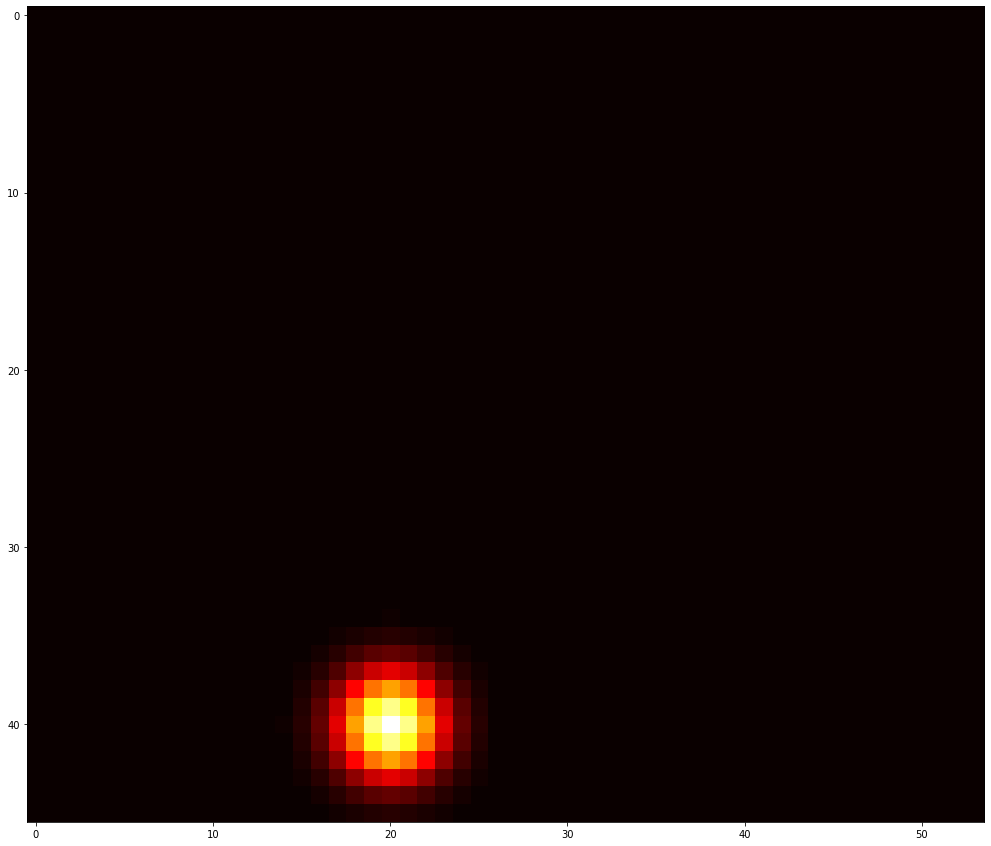

In [64]:
loss_heat = np.zeros((19, 46, 54))
peak = [20, 40]
sig = 2.0
put_heatmap(loss_heat, CocoPart.RShoulder.value, peak, sig)
fig = plt.figure(figsize=(25, 15))
_ = plt.imshow(loss_heat[CocoPart.RShoulder.value], cmap=plt.cm.hot)

(?, ?, ?, 19)


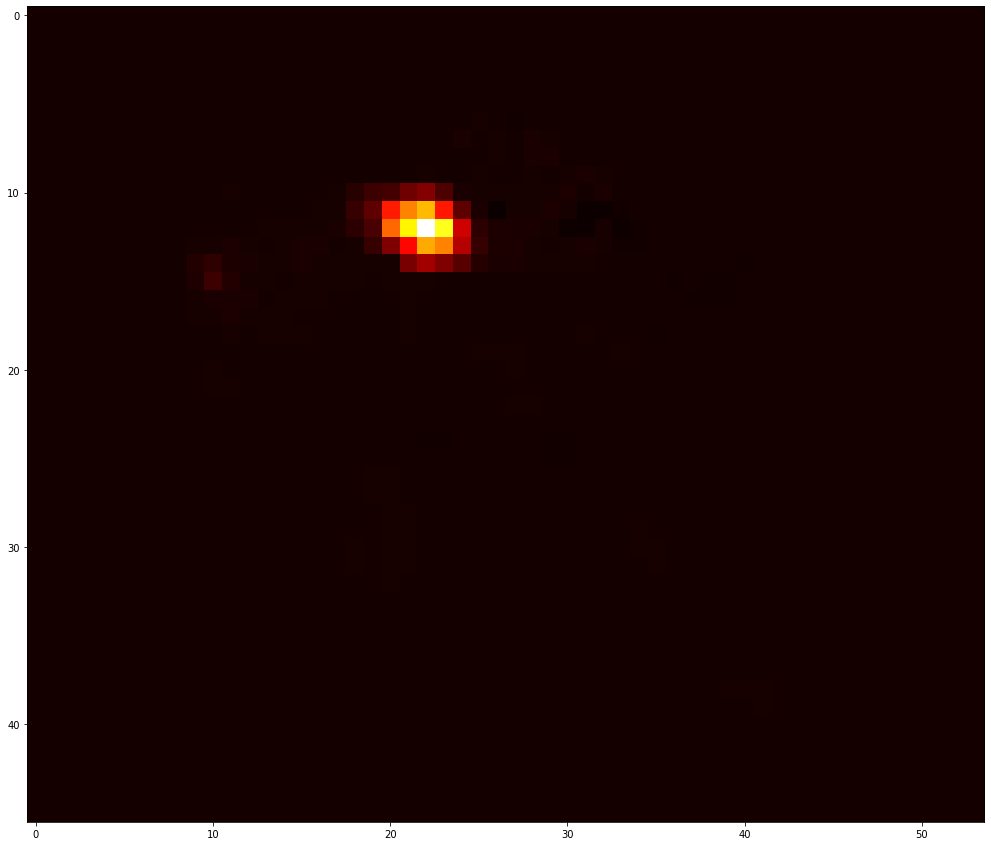

In [65]:
stage = 2
operation = e.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd')
axTensor = operation.outputs[0]
print(axTensor.shape)
output = e.persistent_sess.run(
            axTensor,
            feed_dict={
                e.tensor_image: [image],
                e.upsample_size: [int(e.target_size[1] / 8 * resize_out_ratio), int(e.target_size[0] / 8 * resize_out_ratio)]
            }
        )
attribution = output[0, :, :, CocoPart.RShoulder.value]

fig = plt.figure(figsize=(25, 15))
_ = plt.imshow(attribution, cmap=plt.cm.hot)